# Generate Representations
In this notebook, we generate the inputs for the machine learning model. At the end of this notebook, we will have computed the features for all available data, and generated the pickle files needed to run these models for any available data.

In [1]:
%matplotlib inline
import sys
from glob import glob
sys.path = glob('/projects/CSC249ADCD01/packages/*') + sys.path
from matplotlib import pyplot as plt
import os
import pandas as pd
import numpy as np
import pickle as pkl
import gzip
from stopping_power_ml.io import get_charge_density_interpolator
from stopping_power_ml.features import LocalChargeDensity, IonIonForce, ProjectedAGNIFingerprints, ProjectileVelocity, TimeAverage
from tqdm import tqdm_notebook as tqdm

Configure Parsl

In [2]:
import parsl
from parsl import *
workers = IPyParallelExecutor()
dfk = DataFlowKernel(executors=[workers])

## Load in Dataset
Load in the pickled dataset from `parse-qbox-data`

In [3]:
data = pkl.load(gzip.open('data.pkl.gz', 'rb'))
print('Loaded %d entries'%len(data))

Loaded 50069 entries


Load an example of the simualtion cell

In [4]:
start_frame = pkl.load(open('al_starting_frame.pkl', 'rb'))

## Compute the Representation
We use three kinds of features as input to our machine learning model:

1. *Local Charge Density*: The local electron density at the projectile's current position and several positions in the future and past.
1. *Local Environemnt*: Descriptions of the atom environment around the projectile using the AGNI fingerprints developed by [Botu *et al*](http://pubs.acs.org/doi/10.1021/acs.jpcc.6b10908)
1. *Ion-Ion Repulsion*: The Coulombic repulsion force between the Al atoms and the projectile

### Local Charge Density Features
These features are based on the ground-state electronic structure of Al, as computed using DFT. The original 

In [5]:
%%time
charge = pkl.load(open('density_interp-nosym.pkl', 'rb'))

Wall time: 48.1 ms


In [6]:
charge_features = TimeAverage(start_frame, LocalChargeDensity(start_frame, charge), (0.6,1,4,-0.6,-1), k=6)

Compute the features. First, we define a parallel function with Parsl

In [7]:
def compute_features(featurizer, data, chunks=96):
    """Compute the features for each entry in the dataframe.
    
    :param featurizer: tool used to compute the features
    :param data: pd.DataFrame, data to be featurized
    :param threads_per_worker: int, number of threads to run on each Parsl worker
    :param chunks: int, number of pieces to evaluate in parallel"""
    
    @App('python', dfk)
    def compute_features(chunk):
        return featurizer.featurize_dataframe(chunk, ['position', 'velocity'], inplace=False)

#    chunks = [compute_features(chunk) for chunk in np.array_split(data, chunks)]
#    return pd.concat([c.result() for c in tqdm(chunks, desc='Running')])
    return featurizer.featurize_dataframe(data, ['position', 'velocity'])

In [8]:
%%time
data = compute_features(charge_features, data)

Wall time: 27min 15s


Plot the variables on the random trajectory

In [9]:
subset = data[data['directory'].str.contains('Dv1.0')]

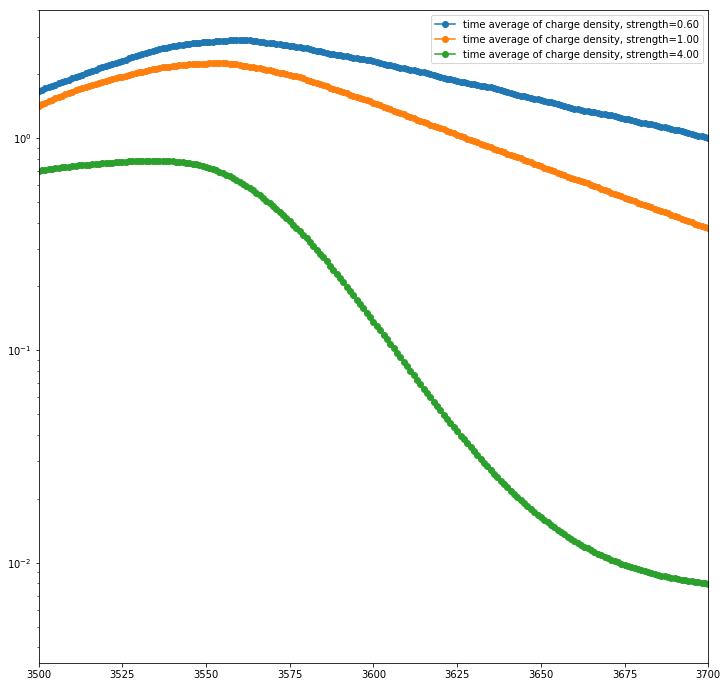

In [10]:
fig, ax = plt.subplots()

labels = charge_features.feature_labels()[:3]
ax.semilogy(subset['timestep'], subset[labels], 'o-', label=labels)

ax.legend(labels)
ax.set_xlim(3500, 3700)
fig.set_size_inches(12, 12)

## Compute AGNI Fingerprints
Use these to describe the local enviroment around a particle

In [11]:
agni_features = ProjectedAGNIFingerprints(start_frame, etas=np.logspace(np.log10(0.8), np.log10(16), 8).tolist(),
                                          use_prim_cell=False)

In [12]:
%%time
#data = agni_features.featurize_dataframe(data, 'atoms')
data = compute_features(agni_features, data) # Turned off while writing this notebook

Wall time: 55.5 s


## Compute Ion-Ion Interaction Forces
Get the repulsion force due to the ion-ion repulsion from the surrounding Al nuclei. Specifically, we compute the force acting on the particle in the direction of travel using the [Ewald summation method](https://en.wikipedia.org/wiki/Ewald_summation).

In [13]:
ewald_features = IonIonForce(start_frame, acc=4)

In [14]:
%%time
data = compute_features(ewald_features, data) 

Wall time: 36.1 s


## Add Velocity as Feature
Just the magnitude of the projectile velocity

In [15]:
velocity_feature = ProjectileVelocity(start_frame)

In [16]:
%%time
data = compute_features(velocity_feature, data) 

Wall time: 3.18 s


## Save everything to disk
Data and featurizers

In [17]:
data.columns

Index(['energy', 'file_id', 'force', 'frame_id', 'position', 'velocity',
       'file', 'timestep', 'displacement', 'directory',
       'time average of charge density, strength=0.60',
       'time average of charge density, strength=1.00',
       'time average of charge density, strength=4.00',
       'time average of charge density, strength=-0.60',
       'time average of charge density, strength=-1.00',
       'AGNI projected eta=8.00e-01', 'AGNI projected eta=1.23e+00',
       'AGNI projected eta=1.88e+00', 'AGNI projected eta=2.89e+00',
       'AGNI projected eta=4.43e+00', 'AGNI projected eta=6.80e+00',
       'AGNI projected eta=1.04e+01', 'AGNI projected eta=1.60e+01',
       'ion-ion repulsion', 'velocity_mag'],
      dtype='object')

In [18]:
data.to_pickle(gzip.open('training_data.pkl.gz', 'wb'))

In [19]:
pkl.dump([charge_features, agni_features, ewald_features, velocity_feature], open('featurizers.pkl', 'wb'))

In [20]:
dfk.cleanup()